In [ ]:
#default_exp rgbkm

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

# Color physics of translucent inks  

## Rendering an RGB image

*Explain Kubelka-Munk theory*

In [ ]:
from inktime import data, rgbkm 

import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
Rg = data.fetch_blackwhite()[:,:,0:3]
# todo: quick fix multiplier 
D = 5 * data.fetch_star()[:,:,0]

In [ ]:
# Hansa yellow RGB KM parameters according to Curtis (1997)
K_hansa = np.array([0.06, 0.21, 1.78]) 
S_hansa = np.array([0.50, 0.88, 0.009])

In [ ]:
refl = rgbkm.reflectance(K_hansa, S_hansa, D, Rg)

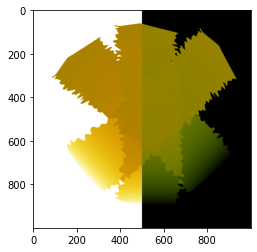

In [ ]:
plt.imshow(refl);

## Functions  

In [ ]:
#export 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 

import scipy.optimize as optimize 


def reflectance(K, S, D, Rg):
    '''Calculates reflectance for single colorant Kubelka-Munk model. 
    
    Based on Nobbs (1997) formulation with modified Saunderson expression for infinite reflectance.  
    Function works for single channel, 3 RGB channels, and spectral data/images with muliple wavelength channels. 
    
    
    Parameters: 
    -----------  
        K: tuple-like (n channels)   
            Colorant absorption coefficients for wavelength or RGB channels
        S: tuple-like (n channels)   
            Colorant scattering coefficients for wavelength or RGB channels
        D: array ( height x width)   
            Colorant thickness image   
        Rg: array (height x width x n) or rgb tuple with shape (3,)  
            Background reflectance image or background color    
         
    Returns:  
    --------   
        refl: array (height x width x n)   
            n-channel reflectance image  
        
    '''
    
    # create uniform background image if Rg is rgb tuple 
    
    Rg = np.array(Rg)
    shape = Rg.shape 
    
    if len(shape) == 1: # understood as rgb tuple 
        
        h, w = D.shape 
        
        Rg_img = np.ones([h, w, 3])
        Rg_img[:,:] = Rg  
        Rg = Rg_img 
    
        shape = Rg.shape  
        
    
    
    n_channels = shape[-1]
    
    K = np.array(K).reshape(1, n_channels)
    S = np.array(S).reshape(1, n_channels)
    
    D = np.array(D).reshape(-1, 1)
    Rg = Rg.reshape(-1, n_channels)
    
    # need to return infinity for K =< 0 or S < 0 in optimization code 
    #pos_S = S >= 0 
    #pos_K = K > 0 # also non-zero
    #ok = pos_S & pos_K
    
    #Rinf = np.zeros([1, n_channels]) 
    Rinf = (S/K) / ((S/K) + 1 + np.sqrt(1 + 2 * (S/K)))
    #Rinf[ok] = (S[ok]/K[ok]) / ((S[ok]/K[ok]) + 1 + np.sqrt(1 + 2 * (S[ok]/K[ok])))
    #Rinf[~ok] = np.infty
    
    Z = D * np.sqrt(K * (K + 2 * S))
    
    Z = np.clip(Z, a_min=0, a_max=50)
    
    beta = np.exp(2 * Z) - 1
    alpha = (1 - Rinf**2) / (1 - Rg * Rinf)
    
    refl = (alpha * Rg + beta * Rinf) / (alpha + beta)
    refl = refl.reshape(shape)
    
    return refl 

In [ ]:
# hide 
def get_optical_density(img, bg_color, blf=True): 
    '''Generates ideal ink optical density model for *img* with background color *bg_color*.'''
    
    # generate uniform background
    
    paper_color_img = np.ones_like(img) 
    paper_color_img[:,:] = bg_color
    
    # not sure if this is needed 
    
    if blf:
        img = cv2.bilateralFilter(img, 10, 0.1, 120) # got these params from 2018-11-16 notebook  
        img_blf = img

    rgb = img.transpose(2, 0, 1)
    r, g, b = rgb 
    
    img_od = mu.normalize_image(-np.log(np.clip(img/paper_color_img, a_min=0, a_max=1)))
    
    return img_od


class PaintDistribution: 
    '''Single colorant layer model'''
    
    def __init__(self, D, Rg, R_meas): 
        '''Initializes statigraphic model with thickness array *D*, background array *Rg* and measured array *R_meas*. '''
        
        self.D = D
        self.Rg = Rg 
        self.R_meas = R_meas 
        
        D_max = self.D.max()
        
        if D_max > 10: 
            print('Warning: found maxium thickness {} larger then 10. Might cause numerical problems.'.format(D_max))
        
    # better .residuals ??     
        
    def residuals(self, KS): 
        '''Returns residuals vector between measured and calculated for *KS*  '''
        
        n_channels = int(len(KS) / 2) 

        K, S = KS[0:n_channels], KS[n_channels: 2*n_channels] # split vector 

        img_calc = reflectance(K, S, self.D, self.Rg)

        img_diff = self.R_meas - img_calc 
        
        is_non_zero_thickness = self.D > 0 

        res = img_diff[is_non_zero_thickness].flatten()
        res = res**2 # check quadratic 
        
        return res 
    
    def fit_KS(self): 
        '''Non-linear fit of K and S for stratigraphic model'''
        
        n_channels = self.Rg.shape[-1] 
        
        KS_start = np.ones(2 * n_channels) 
        
        KS_min = np.ones(2 * n_channels) * 10e-8 # not sure if this avoids numerical problems 
        KS_max = np.ones(2 * n_channels) * 100 # same 
        
        bounds = [KS_min, KS_max]
        
        fit = optimize.least_squares(self.residuals, KS_start, verbose=1, bounds=bounds, xtol=1e-10, ftol=1e-10, gtol=1e-10) # self is callable (function object)
        
        self.K_fit, self.S_fit = fit.x[0:n_channels], fit.x[n_channels:2*n_channels]
        
        self.R_fit = reflectance(self.K_fit, self.S_fit, self.D, self.Rg) # for convenience
        
        return self.K_fit, self.S_fit
    

    
class Ramp_model: 
    
    
    def __init__(self, material, rgb_bg, rgb_1, rgb_2, thickness_1, thickness_2): 
    
        '''Fits K and S to a simple two patch ramp model '''
        
        # should extend to n-patches list but not now 

        self.material = material 
        
        self.Rg = np.ones([3, 4, 3], dtype=float) 
        self.Rg[:,:] = rgb_bg

        self.R_meas = self.Rg.copy()
        self.R_meas[1, 1:3] = np.array([rgb_1, rgb_2]) 

        self.D = np.zeros([3, 4]) 
        self.D[1, 1:3] = [thickness_1, thickness_2] 

        pdist = PaintDistribution(self.D, self.Rg, self.R_meas)

        self.K_fit, self.S_fit = pdist.fit_KS()

        self.rendering = reflectance(self.K_fit, self.S_fit, self.D, self.Rg)

        print('Created 3x4 pixel ramp model object for: "{}"'.format(self.material))